In [2]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [3]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training BKK with *minimal_SARIMAX*

In [4]:
import sys
sys.path.append('../')

In [5]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [6]:
train_set = pd.read_csv('6Hsampled_data_set/SARA/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10 
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/SARA/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10 
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10 
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/SARA/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10 
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10 
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [7]:
order = (1, 0, 2)
seasonal_order = (1, 0, 1, 1461)

exog_order = {}
exog_order['Temp'] = (2, 1, 2)
exog_order['WindSpeed'] = (1, 1, 2)
exog_order['WindDirSin'] = (1, 1, 1)
exog_order['WindDirCos'] = (2, 0, 2)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (1, 0, 1, 1461)
exog_seasonal_order['WindSpeed'] = (1, 1, 0, 1461)
exog_seasonal_order['WindDirSin'] = (1, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (1, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [8]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [9]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        n_iter = 1
        if exog=='WindSpeed': n_iter=10
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=n_iter, learn=True, verbose=1)

100%|██████████| 4383/4383 [04:02<00:00, 18.08it/s]


ITER#0  RMSE:5.421074495132013


100%|██████████| 4383/4383 [04:19<00:00, 16.86it/s]


ITER#0  RMSE:15.038015894104312


100%|██████████| 4383/4383 [04:46<00:00, 15.32it/s]


ITER#1  RMSE:14.644124674690037


100%|██████████| 4383/4383 [04:20<00:00, 16.82it/s]


ITER#2  RMSE:14.32056132829562


100%|██████████| 4383/4383 [04:21<00:00, 16.79it/s]


ITER#3  RMSE:14.118306378020314


100%|██████████| 4383/4383 [03:58<00:00, 18.41it/s]


ITER#4  RMSE:13.940105546971603


100%|██████████| 4383/4383 [03:49<00:00, 19.09it/s]


ITER#5  RMSE:13.76131440183912


100%|██████████| 4383/4383 [04:17<00:00, 17.00it/s]


ITER#6  RMSE:13.575419109702153


100%|██████████| 4383/4383 [04:18<00:00, 16.98it/s]


ITER#7  RMSE:13.377829303675995


100%|██████████| 4383/4383 [04:15<00:00, 17.12it/s]


ITER#8  RMSE:13.16839470977157


100%|██████████| 4383/4383 [04:18<00:00, 16.99it/s]


ITER#9  RMSE:12.94523483497169


100%|██████████| 4383/4383 [04:41<00:00, 15.57it/s]


ITER#0  RMSE:10.305962807024063


100%|██████████| 4383/4383 [05:40<00:00, 12.89it/s]


ITER#0  RMSE:9.347175594155463


#### Saraburi

In [13]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [15:22<00:00,  4.75it/s]


ITER#0  RMSE:16.911281303234457


100%|██████████| 4383/4383 [13:24<00:00,  5.45it/s]


ITER#1  RMSE:16.530480118586787


100%|██████████| 4383/4383 [13:25<00:00,  5.44it/s]


ITER#2  RMSE:15.733736727622643


100%|██████████| 4383/4383 [13:26<00:00,  5.44it/s]


ITER#3  RMSE:14.98472105122573


100%|██████████| 4383/4383 [13:26<00:00,  5.43it/s]


ITER#4  RMSE:14.191440874527773


100%|██████████| 4383/4383 [13:25<00:00,  5.44it/s]


ITER#5  RMSE:13.464046897119115


100%|██████████| 4383/4383 [13:30<00:00,  5.41it/s]


ITER#6  RMSE:12.955801859695306


100%|██████████| 4383/4383 [13:29<00:00,  5.41it/s]


ITER#7  RMSE:12.713139714664603


100%|██████████| 4383/4383 [13:35<00:00,  5.38it/s]


ITER#8  RMSE:12.638095028669687


100%|██████████| 4383/4383 [13:31<00:00,  5.40it/s]

ITER#9  RMSE:12.621512650333633


In [14]:
with open('../model_save/model_sara.model',"wb") as f:
    pickle.dump(model, f)

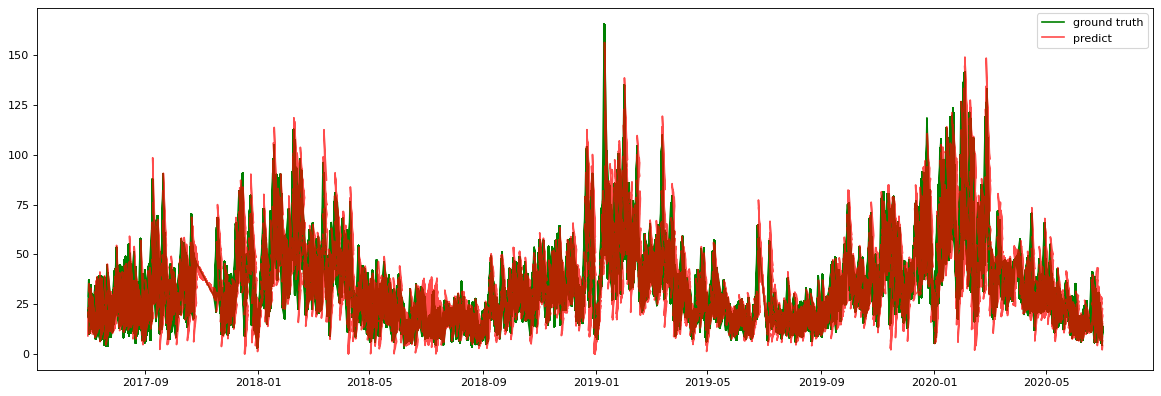

In [15]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [16]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [07:46<00:00,  5.95it/s]

ITER#0  RMSE:11.40674019718906


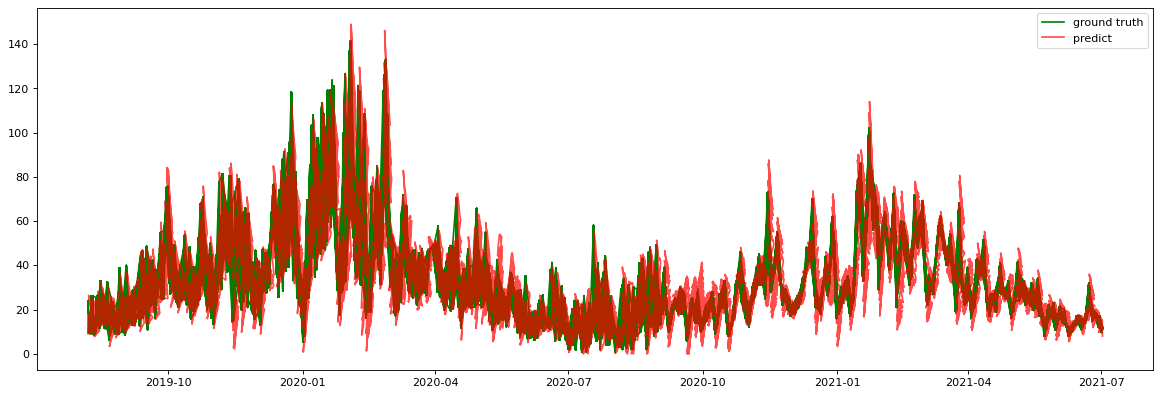

In [17]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [18]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_SARA.csv')